In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

# Data Prep

In [4]:
dat = load_wine()
X_temp = pd.DataFrame(dat['data'], columns=dat['feature_names'])
y_temp = pd.Series(dat['target'])
y_temp = y_temp.rename('target')
X_temp.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
full_dat = pd.concat([X_temp,y_temp], axis=1)
full_dat = full_dat[full_dat['target'].isin([0,1])]
full_dat.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [6]:
full_dat.shape

(130, 14)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
X = full_dat.drop(columns='target')
y = full_dat['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
standardize = StandardScaler()
X_train = standardize.fit_transform(X_train)
X_test = standardize.transform(X_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)


# Base Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [11]:
clf = LogisticRegression(penalty=None, max_iter=100_000, verbose=5, n_jobs=-1)
clf.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


LogisticRegression(max_iter=100000, n_jobs=-1, penalty=None, verbose=5)

In [12]:
clf.coef_

array([[-4.80118387, -1.65497808, -3.85017981,  5.24783838, -0.5094167 ,
         1.50646929, -1.1695847 ,  0.60318034,  0.15841503, -1.47918358,
         0.70608525, -3.29186022, -7.09635185]])

In [13]:
from sklearn.metrics import log_loss

y_train_preds_proba = clf.predict_proba(X_train)
loss = log_loss(y_train, y_train_preds_proba[:,1])
round(loss, 5)

0.00025

# Maximum Gradient Coordinate Descent

$$
\nabla{f(w)} = \sum_{i=1}^n \frac{-y^{(i)}x^{(i)}}{1+\exp(y^{(i)}w^T x^{(i)})}
$$

In [14]:
w_0 = np.zeros(X_train.shape[1])
w_0 = np.array(w_0).reshape(-1, 1)

In [15]:
def max_grad_logistic(w, X, y):
    z = y * (X @ w)
    z = np.clip(z, -500, 500)
    exp_term = np.exp(z)
    grad = np.sum((-y * X) / (1 + exp_term), axis=0)
    return grad

max_grad_logistic(w_0, X_train, y_train)



array([ 20.88678612,   0.13063692,   8.27721288, -12.65425015,
        11.51454032,  13.38346666,  15.84164915,  -9.08597012,
         8.27757156,  18.93856729,   2.81122556,  11.1203019 ,
        22.35311923])

In [25]:
def grad_descent(X, y, w, eta= 0.001, tol=1e-3, epochs = 10000):
    losses = []
    d = X.shape[1]

    for i in range(epochs):
        grad = max_grad_logistic(w, X, y)
        j = np.argmax(np.abs(grad))
        w[j] -= eta * grad[j]

        z = -y * (X @ w)
        z = np.clip(z, -500, 500)

        loss = np.sum(np.log(1 + np.exp(z)))
        losses.append(loss)

        if np.linalg.norm(grad) < tol:
            break
    return w, losses

In [34]:
epochs = 1_000_000
w, losses = grad_descent(X_train, y_train, w_0, epochs=epochs)

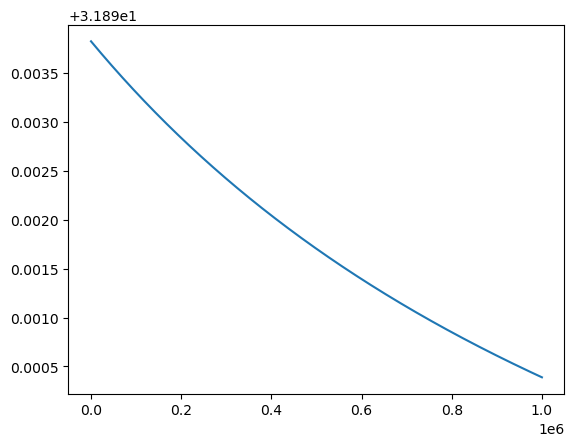

In [35]:
plt.plot(np.arange(0, epochs), losses)

In [37]:
w

array([[ -3.18610612],
       [ -2.52025234],
       [ -1.97240141],
       [  4.55882384],
       [  0.35588314],
       [  0.63769645],
       [ -0.14272137],
       [  0.        ],
       [  0.        ],
       [ -2.74299045],
       [  0.12208143],
       [ -2.54176524],
       [-10.51110757]])

In [38]:
clf.coef_

array([[-4.80118387, -1.65497808, -3.85017981,  5.24783838, -0.5094167 ,
         1.50646929, -1.1695847 ,  0.60318034,  0.15841503, -1.47918358,
         0.70608525, -3.29186022, -7.09635185]])